In [1]:
from preprocessor import Preprocessor
from batch_generator import BatchGenerator
from modelling import Mothership
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# batch_generator = BatchGenerator(pp, 64)
batch_generator = BatchGenerator(64, 64)

In [3]:
model = Mothership(27, [102, 42], 22, [102, 102, 42], 10, [2, 2], [2, 2, 2])
#model = Mothership(27, [], 22, [], 10, [], [])

In [6]:
model.compile(Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [7]:
model.fit_generator(batch_generator, epochs=3)

Epoch 1/3
773/773 [==============================] - 13s 17ms/step - loss: 0.4831 - acc: 0.7837
Epoch 2/3
773/773 [==============================] - 12s 16ms/step - loss: 0.4817 - acc: 0.7850 1s - los
Epoch 3/3
773/773 [==============================] - 12s 16ms/step - loss: 0.4805 - acc: 0.7864


In [8]:
import sys

In [9]:
sys.path.append('../nikita')

In [10]:
from evaluating import permutation_importance

In [11]:
batch_generator = BatchGenerator(1024, 1024)

In [12]:
import pickle

In [29]:
with open('pro_feature_dict.pickle', 'rb') as file:
    pfd = pickle.load(file)

In [30]:
len(pfd)

10015

In [31]:
fn = {
  "que": [
    "students_location",
    "students_state",
    "students_questions_asked",
    "students_average_question_age",
    "students_average_question_body_length",
    "students_average_answer_body_length",
    "students_date_joined_time",
    "students_date_joined_doy_sin",
    "students_date_joined_doy_cos",
    "students_date_joined_dow",
    "questions_body_length",
    "questions_date_added_time",
    "questions_date_added_doy_sin",
    "questions_date_added_doy_cos",
    "questions_date_added_dow",
    "questions_date_added_hour_sin",
    "questions_date_added_hour_cos",
  ],
  "pro": [
    "professionals_industry",
    "professionals_location",
    "professionals_state",
    "professionals_questions_answered",
    "professionals_average_question_age",
    "professionals_average_question_body_length",
    "professionals_average_answer_body_length",
    "professionals_email_activated",
    "professionals_date_joined_time",
    "professionals_date_joined_doy_sin",
    "professionals_date_joined_doy_cos",
    "professionals_date_joined_dow",
  ]
}

In [34]:
fn['que'] += [f'que_emb_{i}' for i in range(10)]

In [35]:
fn['pro'] += [f'pro_emb_{i}' for i in range(10)]

In [50]:
fn['text'] = [f'que_emb_{i}' for i in range(10)] + [f'pro_emb_{i}' for i in range(10)]

In [36]:
len(fn['que']), len(fn['pro'])

(27, 22)

In [33]:
batch_generator[0][0][0].shape, batch_generator[0][0][1].shape

((2048, 27), (2048, 22))

In [58]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [40]:
import evaluating

In [55]:
import imp
imp.reload(evaluating)

<module 'evaluating' from '../nikita\\evaluating.py'>

In [56]:
fi = evaluating.permutation_importance(model, batch_generator[0][0][0], batch_generator[0][0][1], batch_generator[0][1], fn)

2048/2048 [==============================] - ETA: 12 - ETA: 0 - 0s 141us/step


In [57]:
fi

,importance
questions_date_added_dow,-0.000096
questions_date_added_hour_cos,-0.000091
questions_date_added_hour_sin,-0.000068
students_date_joined_dow,0.000125
que_emb_4,0.000259
professionals_date_joined_dow,0.000449
que_emb_7,0.000563
que_emb_8,0.001233
students_questions_asked,0.001272
que_emb_6,0.001895


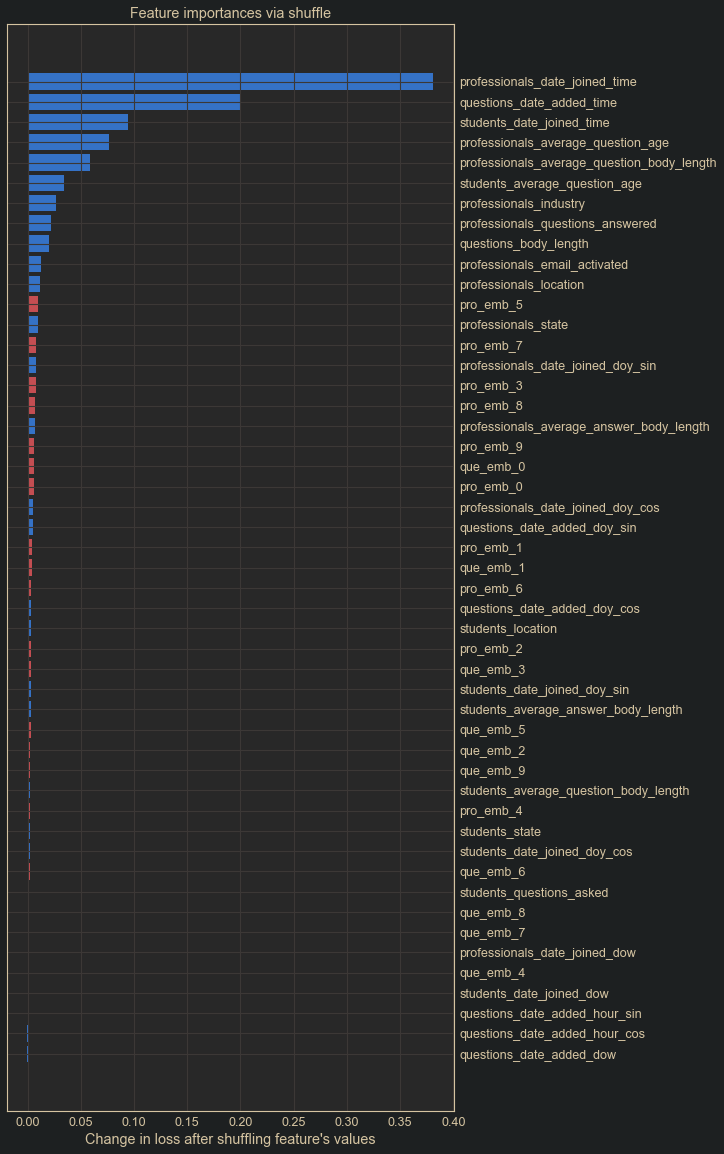

In [59]:
evaluating.plot_fi(fi, fn)